# Decision Trees (DT)

### Objective: 
- Setup DT classifier 
- Check feature importance w/ information gain
- Utilize log-loss as evaulation metrics

10/5/2018<br>
Mooyoung Lee

# Iris dataset

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns = iris.feature_names)
y = iris.target.astype(np.int)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# Scale data

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
X = scaler.fit_transform(X)

# DT classifier optimization w/ given dataset



In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

tuned_parameters = {'criterion' : ['gini','entropy'],
                   'min_samples_split' : [2,4,6,8,10]}

clf = RandomizedSearchCV(DecisionTreeClassifier(), tuned_parameters, cv=10, n_iter = 10)
clf.fit(X, y)

## Print Results
print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("Grid scores on development set:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'min_samples_split': 6, 'criterion': 'gini'}
Grid scores on development set:

0.953 (+/-0.085) for {'min_samples_split': 2, 'criterion': 'gini'}
0.953 (+/-0.085) for {'min_samples_split': 4, 'criterion': 'gini'}
0.960 (+/-0.065) for {'min_samples_split': 6, 'criterion': 'gini'}
0.960 (+/-0.065) for {'min_samples_split': 8, 'criterion': 'gini'}
0.960 (+/-0.065) for {'min_samples_split': 10, 'criterion': 'gini'}
0.953 (+/-0.085) for {'min_samples_split': 2, 'criterion': 'entropy'}
0.953 (+/-0.085) for {'min_samples_split': 4, 'criterion': 'entropy'}
0.960 (+/-0.065) for {'min_samples_split': 6, 'criterion': 'entropy'}
0.960 (+/-0.065) for {'min_samples_split': 8, 'criterion': 'entropy'}
0.960 (+/-0.065) for {'min_samples_split': 10, 'criterion': 'entropy'}


# DT Cross Validation

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from sklearn.model_selection import StratifiedKFold
cv_obj = StratifiedKFold(n_splits = 10, shuffle = True)

clf = DecisionTreeClassifier(criterion = 'gini', min_samples_split = 2)

result = []
result_conf = []
for train_index, test_index in cv_obj.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    
    acc = accuracy_score(y_true = y_test, y_pred = y_hat)
    conf = confusion_matrix(y_true = y_test, y_pred = y_hat)
    f1 = f1_score(y_true = y_test, y_pred = y_hat, average = 'weighted')        # Choose 'binary' for binary class.
    logLoss = log_loss(y_true = y_test, y_pred = clf.predict_proba(X_test))  # Need probabily values
    
    result.append([acc,f1,logLoss])   # save result scores
    result_conf.append(conf)
    
# Result Summary
result_fold = pd.DataFrame(result, columns = ['Accuracy','F1','Log-Loss'])
print('\nCV result :\n', result_fold)
print('\nCV average :\n', result_fold.mean())


CV result :
    Accuracy        F1      Log-Loss
0  0.866667  0.866667  4.605170e+00
1  0.866667  0.861111  4.605170e+00
2  0.866667  0.866667  4.605170e+00
3  0.933333  0.932660  2.302585e+00
4  1.000000  1.000000  2.109424e-15
5  1.000000  1.000000  2.109424e-15
6  0.866667  0.866667  4.605170e+00
7  1.000000  1.000000  2.109424e-15
8  1.000000  1.000000  2.109424e-15
9  1.000000  1.000000  2.109424e-15

CV average :
 Accuracy    0.940000
F1          0.939377
Log-Loss    2.072327
dtype: float64


# CV result plot

Text(0,0.5,'See Legend')

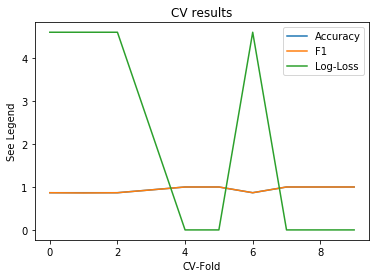

In [5]:
result_fold.plot()
plt.title('CV results')
plt.xlabel('CV-Fold')
plt.ylabel('See Legend')

# Feature Importance from gini index

Text(0.5,1,'Feature Importance')

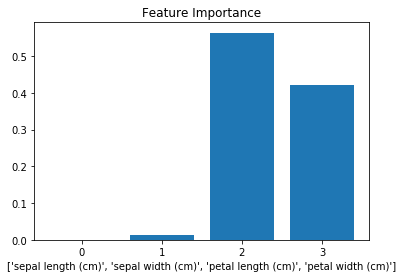

In [6]:
clf.fit(X, y) # using all data
imp = clf.feature_importances_

plt.bar(range(len(imp)), imp)
plt.xlabel(iris.feature_names)
plt.xticks(np.arange(X.shape[1]))
plt.title('Feature Importance')

# Decision Paths

In [7]:
# Source: Online
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print (node)

In [8]:
get_lineage(clf, iris.feature_names)

(0, 'l', 0.24576270580291748, 'petal length (cm)')
1
(0, 'r', 0.24576270580291748, 'petal length (cm)')
(2, 'l', 0.6875, 'petal width (cm)')
(3, 'l', 0.6694915294647217, 'petal length (cm)')
(4, 'l', 0.6458333730697632, 'petal width (cm)')
5
(0, 'r', 0.24576270580291748, 'petal length (cm)')
(2, 'l', 0.6875, 'petal width (cm)')
(3, 'l', 0.6694915294647217, 'petal length (cm)')
(4, 'r', 0.6458333730697632, 'petal width (cm)')
6
(0, 'r', 0.24576270580291748, 'petal length (cm)')
(2, 'l', 0.6875, 'petal width (cm)')
(3, 'r', 0.6694915294647217, 'petal length (cm)')
(7, 'l', 0.6041666269302368, 'petal width (cm)')
8
(0, 'r', 0.24576270580291748, 'petal length (cm)')
(2, 'l', 0.6875, 'petal width (cm)')
(3, 'r', 0.6694915294647217, 'petal length (cm)')
(7, 'r', 0.6041666269302368, 'petal width (cm)')
(9, 'l', 0.7542372941970825, 'petal length (cm)')
10
(0, 'r', 0.24576270580291748, 'petal length (cm)')
(2, 'l', 0.6875, 'petal width (cm)')
(3, 'r', 0.6694915294647217, 'petal length (cm)')
(7

# Visualize Decision path 01

In [9]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file = None)

graph = graphviz.Source(dot_data)
graph.format = 'png' # change output format
graph.render('iris')

'iris.png'

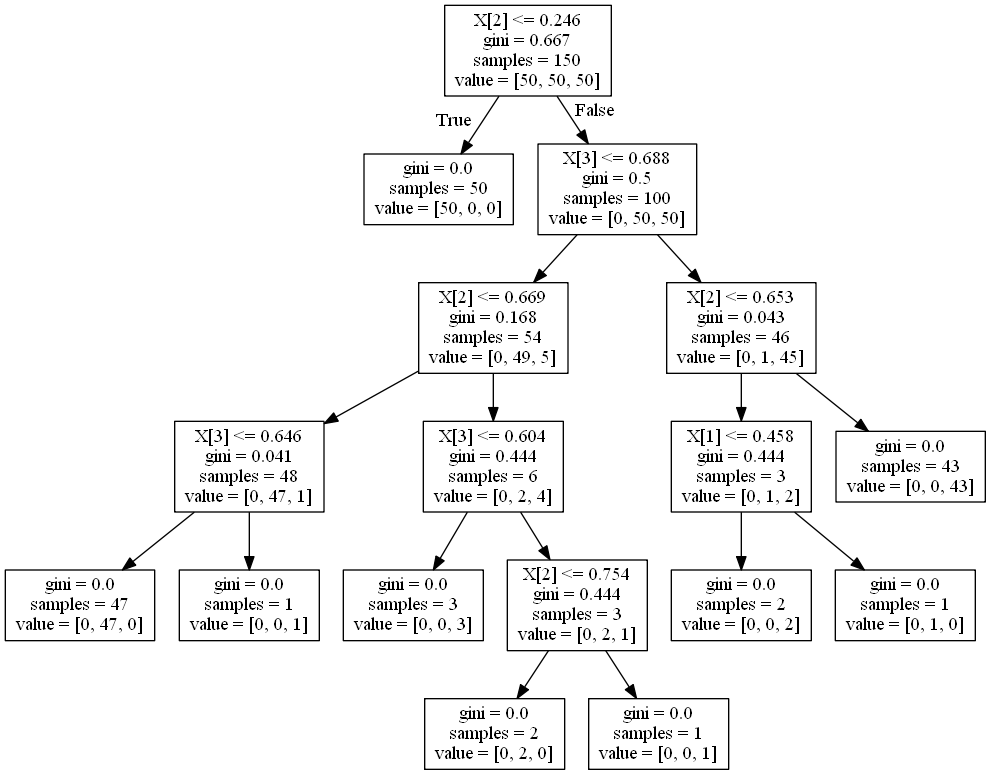

In [10]:
from IPython.display import Image
Image('iris.png')

# Visualize Decision Path 02

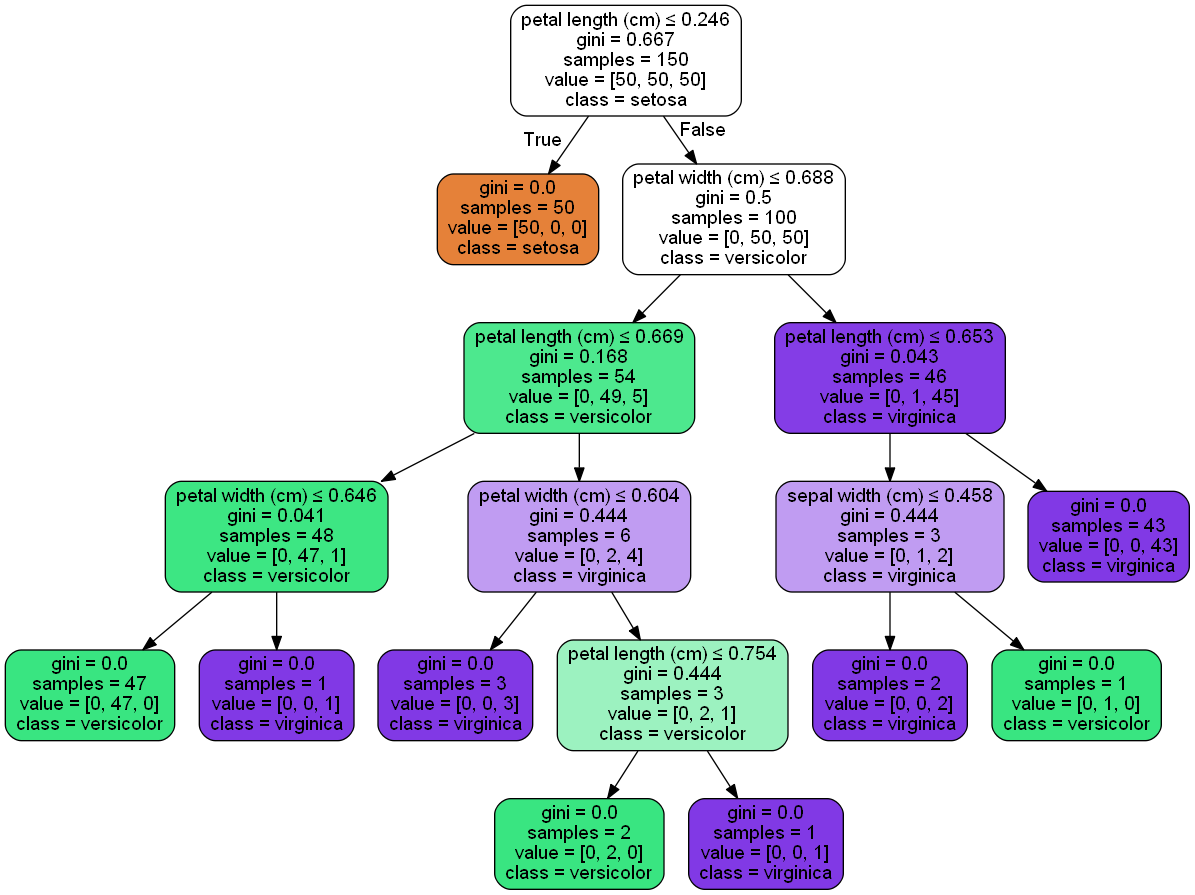

In [11]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.format = 'png' # change output format
graph.render('iris2')
Image('iris2.png')